---
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv("~/Documents/Github/stat215_final_project/data/counts.csv")
df = df.set_index('countyFIPS','date')
df1 = pd.read_csv("~/Documents/Github/stat215_final_project/data/county_data_abridged.csv")
df2 = df1[['countyFIPS','CountyName','State']].set_index('countyFIPS')
data = df2.join(df, how = 'inner')
cali = data[data['State'] == 'California']

In [3]:
CountyCases = pd.DataFrame(cali.groupby('CountyName')['n_cases'].max().sort_values(ascending= False))
CountyDeaths = pd.DataFrame(cali.groupby('CountyName')['n_deaths'].max().sort_values(ascending= False))

In [12]:
baylist = ["Alameda", "Contra Costa", "Marin","Napa", "San Francisco", 
           "San Mateo", "Santa Clara", "Solano", "Sonoma"]
bayCases = cali[cali['CountyName'].isin(baylist)]

In [15]:
bayCases.groupby('CountyName')['n_cases'].max().sort_values(ascending= False)

CountyName
Santa Clara      34292
Alameda          29476
Contra Costa     24275
San Francisco    15417
San Mateo        14148
Sonoma           12049
Solano           10036
Marin             7753
Napa              2931
Name: n_cases, dtype: int64

In [16]:
bayCases.groupby('CountyName')['n_deaths'].max().sort_values(ascending= False)

CountyName
Alameda          512
Santa Clara      476
Contra Costa     261
San Mateo        170
San Francisco    160
Sonoma           157
Marin            129
Solano            81
Napa              17
Name: n_deaths, dtype: int64

In [6]:
CountyCases.head(25)

,n_cases
CountyName,
Los Angeles,395843
San Bernardino,93019
Riverside,82286
San Diego,81084
Orange,77819
Kern,41827
Fresno,37994
Sacramento,36630
Santa Clara,34292


In [98]:
CountyDeaths.head()

,n_deaths
CountyName,
Los Angeles,7639
Orange,1577
Riverside,1437
San Bernardino,1129
San Diego,997


In [99]:
# Functions for testing stationarity

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

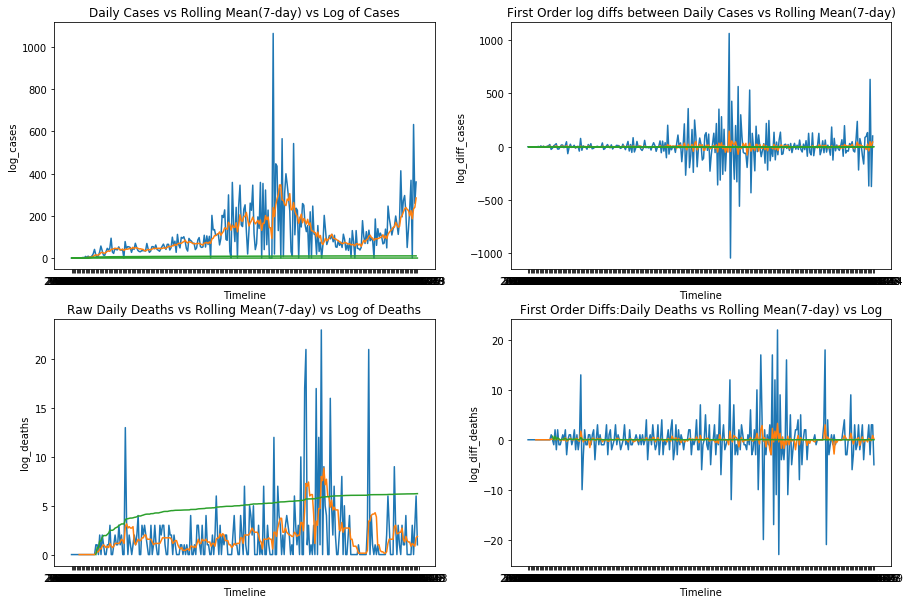

In [100]:
# Construct Alameda county data

# Daily
Alameda = cali[cali['CountyName'] == 'Alameda']
Alameda['daily_cases'] = Alameda['n_cases'].diff()
Alameda['daily_deaths'] = Alameda['n_deaths'].diff()
Alameda['one_diff_cases'] = Alameda['daily_cases'].diff()
Alameda['one_diff_deaths'] = Alameda['daily_deaths'].diff()

#log

Alameda['log_cases'] = np.log(Alameda['n_cases'])
Alameda['log_deaths'] = np.log(Alameda['n_deaths'])
Alameda['log_diff_cases'] = Alameda['log_cases'].diff()
Alameda['log_diff_deaths'] = Alameda['log_deaths'].diff()


# Construct daily, log counts and first order differences within daily counts and log counts
df3 = Alameda[['date', 'n_cases','n_deaths','daily_cases','daily_deaths', 'one_diff_cases','one_diff_deaths', 'log_cases', 'log_deaths',
              'log_diff_cases', 'log_diff_deaths']]

df3['rolling_mean_cases'] = Alameda.daily_cases.rolling(window=7).mean()
df3['rolling_mean_deaths'] = Alameda.daily_deaths.rolling(window=7).mean()
df3['rolling_mean_one_diff_cases'] = Alameda.one_diff_cases.rolling(window=7).mean()
df3['rolling_mean_one_diff_deaths'] = Alameda.one_diff_deaths.rolling(window=7).mean()


# Analysis of daily Infections & deaths
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.lineplot(data=df3, x="date", y="daily_cases")
sns.lineplot(data=df3, x="date", y="rolling_mean_cases")
sns.lineplot(data=df3, x="date", y="log_cases")
plt.xlabel("Timeline")
plt.title('Daily Cases vs Rolling Mean(7-day) vs Log of Cases')

plt.subplot(2,2,2)
sns.lineplot(data=df3, x="date", y="one_diff_cases")
sns.lineplot(data=df3, x="date", y="rolling_mean_one_diff_cases")
sns.lineplot(data=df3, x="date", y="log_diff_cases")
plt.xlabel("Timeline")
plt.title('First Order log diffs between Daily Cases vs Rolling Mean(7-day)')

plt.subplot(2,2,3)
sns.lineplot(data=df3, x="date", y="daily_deaths")
sns.lineplot(data=df3, x="date", y="rolling_mean_deaths")
sns.lineplot(data=df3, x="date", y="log_deaths")
plt.xlabel("Timeline")
plt.title('Raw Daily Deaths vs Rolling Mean(7-day) vs Log of Deaths')

plt.subplot(2,2,4)
sns.lineplot(data=df3, x="date", y="one_diff_deaths")
sns.lineplot(data=df3, x="date", y="rolling_mean_one_diff_deaths")
sns.lineplot(data=df3, x="date", y="log_diff_deaths")


plt.xlabel("Timeline")
plt.title('First Order Diffs:Daily Deaths vs Rolling Mean(7-day) vs Log')

plt.show()

# prepare data

df4 = df3.reset_index().drop('countyFIPS', axis = 1)
df4 = df4.set_index('date')
df4.index = pd.to_datetime(df4.index)
df4.index.freq = 'd'
data= df4['2020-04-01':]

Results of Dickey-Fuller Test:
Test Statistic                  -3.451167
p-value                          0.009333
#Lags Used                       8.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64
Results of KPSS Test:
Test Statistic            1.543366
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.002243
ar.L1       -0.236717
ar.L2       -0.309001
ar.L3       -0.300790
ma.L1       -0.531925
ma.L2        0.081222
ma.L3        0.304205
ma.L4       -0.111304
ma.L5       -0.210034
ma.L6        0.650007
ma.L7       -0.013470
sigma2       0.000277
dtype: float64
210.36295579877878 RMSE


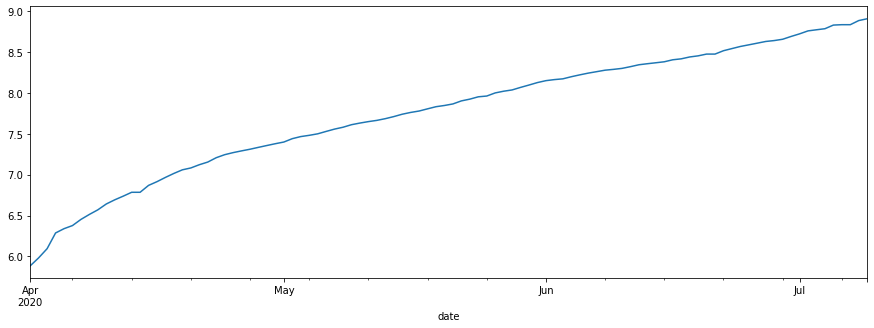

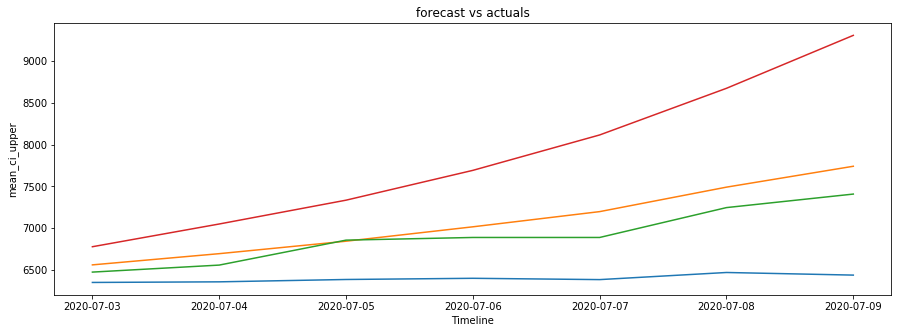

In [101]:
# cases- scenario 1

# test for stationarity
adf_test(data.log_cases)
kpss_test(data.log_cases)

# modelling
data1 = data[0:100]
endog = data1['log_cases']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-07-02']
test_endog = endog['2020-07-03':'2020-07-09']
training_mod = sm.tsa.SARIMAX(training_endog, order=(3, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_cases']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.058700
p-value                          0.261443
#Lags Used                      15.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64
Results of KPSS Test:
Test Statistic            1.53923
p-value                   0.01000
Lags Used                15.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.002836
ar.L1       -0.549991
ar.L2       -0.402448
ar.L3       -0.159946
ar.L4       -0.207508
ar.L5       -0.126054
ar.L6       -0.112522
ar.L7       -0.068822
ar.L8        0.046319
ar.L9       -0.001630
ar.L10      -0.082268
ar.L11      -0.366144
ar.L12       0.072346
ar.L13       0.104889
ar.L14       0.056373
ma.L1       -0.378728
ma.L2       -0.402479
ma.L3        0.033542
ma.L4        0.021925
ma.L5        0.048139
ma.L6       -0.081225
ma.L7        0.068656
sigma2       0.002146
dtype: float64
2.2294894286985425 RMSE


Text(0.5, 1.0, 'forecast vs actuals')

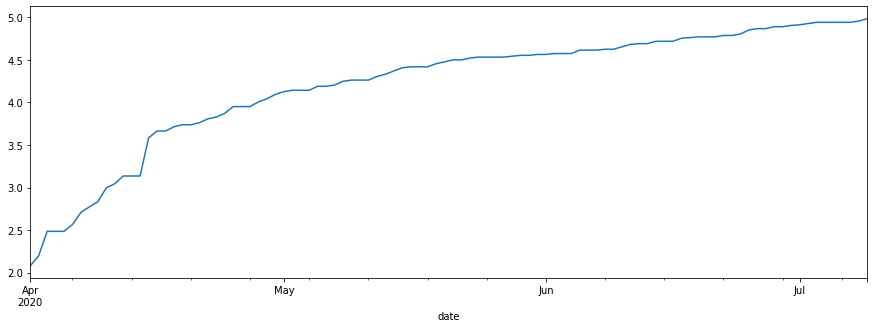

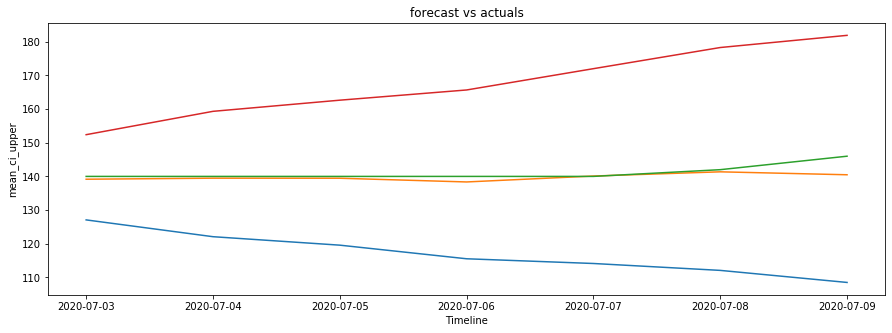

In [103]:
# deaths- scenario 1

# test for stationarity
adf_test(data.log_deaths)
kpss_test(data.log_deaths)

# modelling
endog = data1['log_deaths']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-07-02']
test_endog = endog['2020-07-03':'2020-07-09']
training_mod = sm.tsa.SARIMAX(training_endog, order=(14, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_deaths']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')



/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.000859
ar.L1       -1.298962
ar.L2       -1.156051
ar.L3       -0.402356
ma.L1        0.063472
ma.L2        0.035948
ma.L3       -0.604172
ma.L4       -0.274814
ma.L5       -0.047753
ma.L6       -0.170257
ma.L7        0.343630
sigma2       0.000115
dtype: float64
189.5719287581044 RMSE


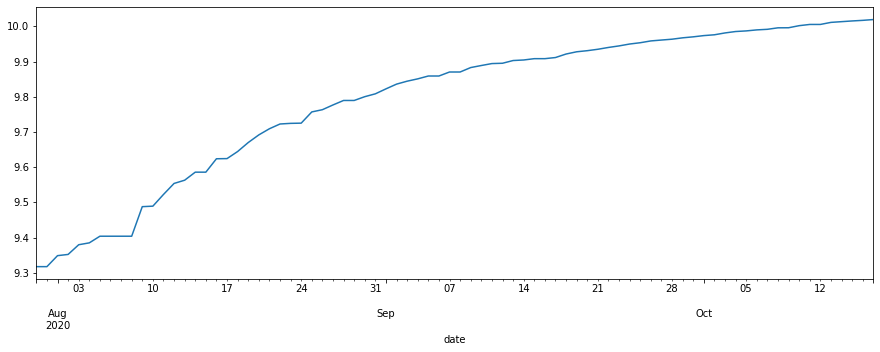

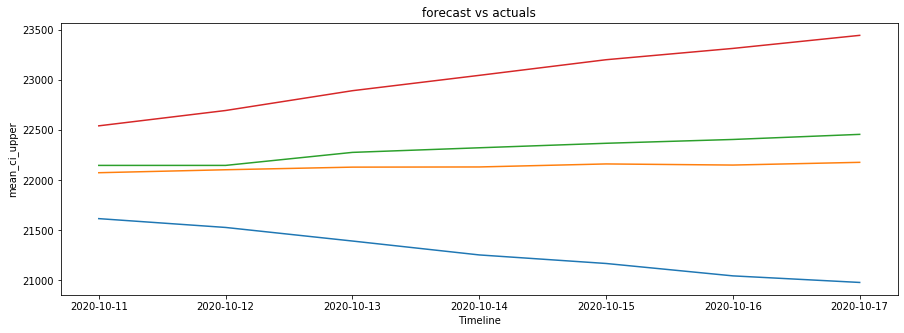

In [104]:
# cases-scenario 2
data1 = data[120:200]
endog = data1['log_cases']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-10-10']
test_endog = endog['2020-10-11':'2020-10-17']
training_mod = sm.tsa.SARIMAX(training_endog, order=(3, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_cases']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.000284
ar.L1       -0.574587
ar.L2       -0.312003
ar.L3       -0.247495
ar.L4       -0.162567
ar.L5       -0.276738
ar.L6       -0.177451
ar.L7       -0.110024
ar.L8        0.140258
ar.L9        0.123589
ar.L10      -0.051741
ar.L11      -0.008053
ar.L12       0.127215
ar.L13       0.110904
ar.L14       0.132797
ma.L1       -0.429925
ma.L2       -0.162460
ma.L3       -0.044193
ma.L4        0.068426
ma.L5       -0.059462
ma.L6       -0.117215
ma.L7       -0.017841
sigma2       0.000274
dtype: float64
7.9195790198289435 RMSE


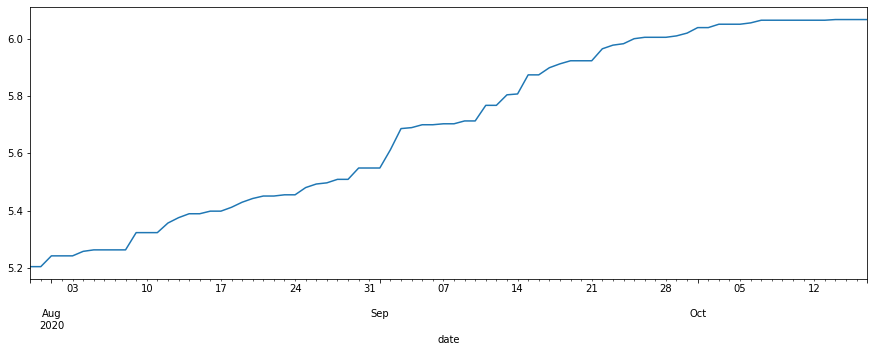

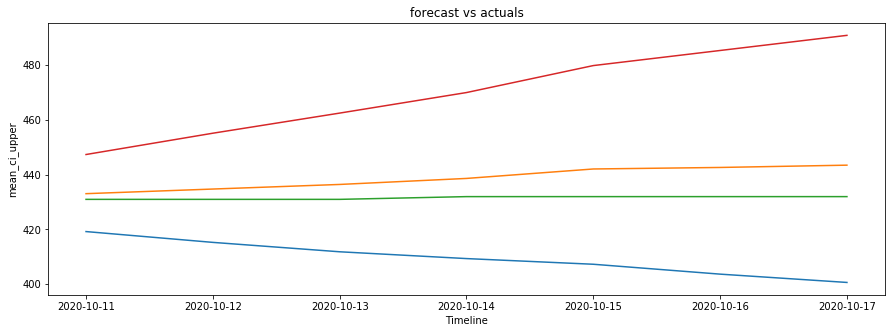

In [107]:
# deaths-scenario 2
data1 = data[120:200]
endog = data1['log_deaths']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-10-10']
test_endog = endog['2020-10-11':'2020-10-17']
training_mod = sm.tsa.SARIMAX(training_endog, order=(14, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_deaths']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

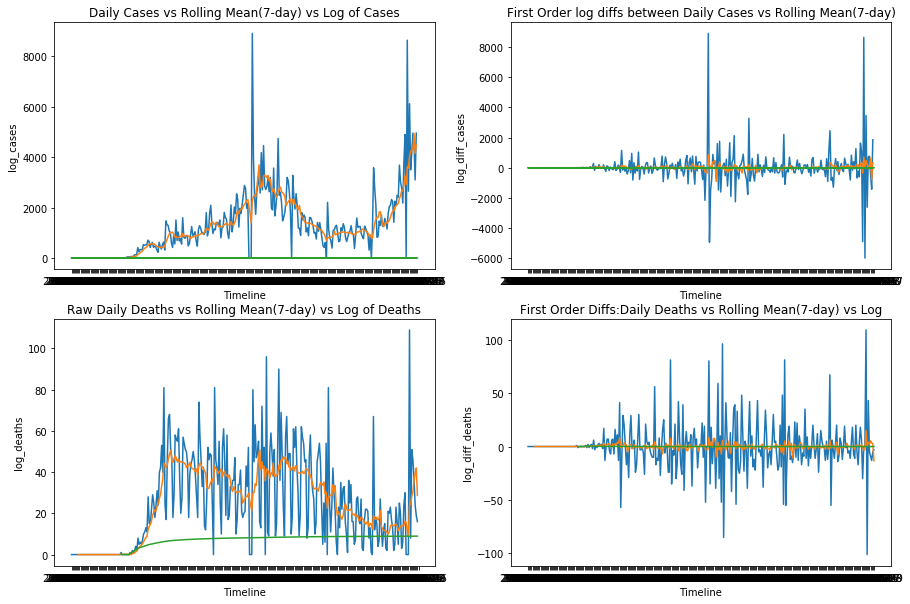

In [108]:
# Los Angeles
#daily
Los_Angeles = cali[cali['CountyName'] == 'Los Angeles']
Los_Angeles['daily_cases'] = Los_Angeles['n_cases'].diff()
Los_Angeles['daily_deaths'] = Los_Angeles['n_deaths'].diff()
Los_Angeles['one_diff_cases'] = Los_Angeles['daily_cases'].diff()
Los_Angeles['one_diff_deaths'] = Los_Angeles['daily_deaths'].diff()


#log

Los_Angeles['log_cases'] = np.log(Los_Angeles['n_cases'])
Los_Angeles['log_deaths'] = np.log(Los_Angeles['n_deaths'])
Los_Angeles['log_diff_cases'] = Los_Angeles['log_cases'].diff()
Los_Angeles['log_diff_deaths'] = Los_Angeles['log_deaths'].diff()


# Construct daily, log counts and first order differences within daily counts and log counts
df3 = Los_Angeles[['date', 'n_cases','n_deaths','daily_cases','daily_deaths', 'one_diff_cases','one_diff_deaths', 'log_cases', 'log_deaths',
              'log_diff_cases', 'log_diff_deaths']]


df3['rolling_mean_cases'] = Los_Angeles.daily_cases.rolling(window=7).mean()
df3['rolling_mean_deaths'] = Los_Angeles.daily_deaths.rolling(window=7).mean()
df3['rolling_mean_one_diff_cases'] = Los_Angeles.one_diff_cases.rolling(window=7).mean()
df3['rolling_mean_one_diff_deaths'] = Los_Angeles.one_diff_deaths.rolling(window=7).mean()

# Analysis of daily Infections & deaths
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.lineplot(data=df3, x="date", y="daily_cases")
sns.lineplot(data=df3, x="date", y="rolling_mean_cases")
sns.lineplot(data=df3, x="date", y="log_cases")
plt.xlabel("Timeline")
plt.title('Daily Cases vs Rolling Mean(7-day) vs Log of Cases')

plt.subplot(2,2,2)
sns.lineplot(data=df3, x="date", y="one_diff_cases")
sns.lineplot(data=df3, x="date", y="rolling_mean_one_diff_cases")
sns.lineplot(data=df3, x="date", y="log_diff_cases")
plt.xlabel("Timeline")
plt.title('First Order log diffs between Daily Cases vs Rolling Mean(7-day)')

plt.subplot(2,2,3)
sns.lineplot(data=df3, x="date", y="daily_deaths")
sns.lineplot(data=df3, x="date", y="rolling_mean_deaths")
sns.lineplot(data=df3, x="date", y="log_deaths")
plt.xlabel("Timeline")
plt.title('Raw Daily Deaths vs Rolling Mean(7-day) vs Log of Deaths')

plt.subplot(2,2,4)
sns.lineplot(data=df3, x="date", y="one_diff_deaths")
sns.lineplot(data=df3, x="date", y="rolling_mean_one_diff_deaths")
sns.lineplot(data=df3, x="date", y="log_diff_deaths")


plt.xlabel("Timeline")
plt.title('First Order Diffs:Daily Deaths vs Rolling Mean(7-day) vs Log')

plt.show()

# prepare data

df4 = df3.reset_index().drop('countyFIPS', axis = 1)
df4 = df4.set_index('date')
df4.index = pd.to_datetime(df4.index)
df4.index.freq = 'd'
data= df4['2020-04-01':]

Results of Dickey-Fuller Test:
Test Statistic                  -1.680679
p-value                          0.441094
#Lags Used                      15.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64
Results of KPSS Test:
Test Statistic            1.460778
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.000544
ar.L1       -0.623919
ar.L2        0.573495
ar.L3        0.448830
ma.L1        0.240510
ma.L2       -0.816857
ma.L3       -0.273834
ma.L4       -0.036364
ma.L5       -0.420704
ma.L6        0.127298
ma.L7        0.343602
sigma2       0.000221
dtype: float64
4767.863236748032 RMSE


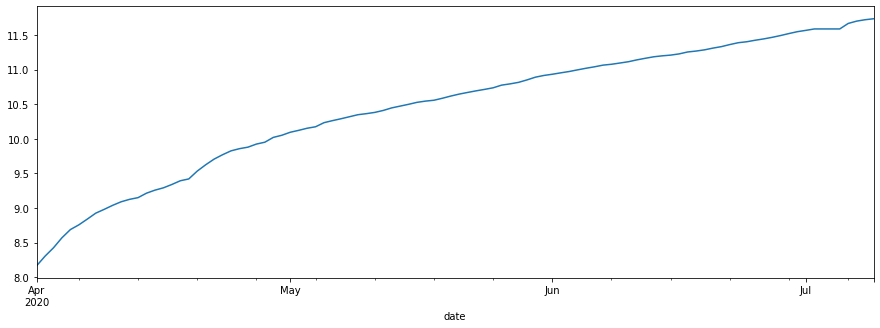

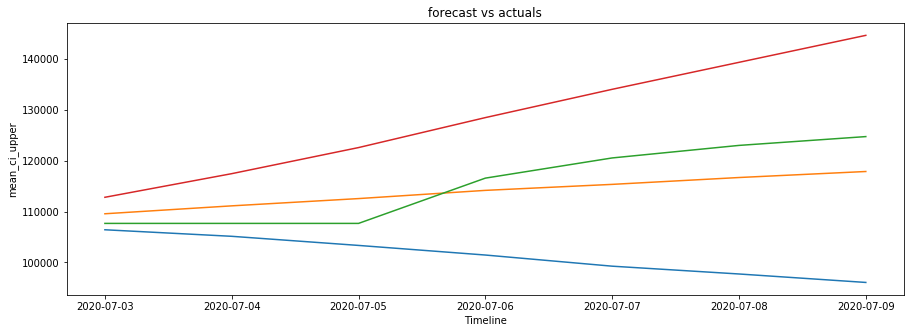

In [109]:
# cases-scenario 1

# test for stationarity
adf_test(data.log_cases)
kpss_test(data.log_cases)

# modelling

import statsmodels.api as sm
data1 = data[0:100]
endog = data1['log_cases']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-07-02']
test_endog = endog['2020-07-03':'2020-07-09']
training_mod = sm.tsa.SARIMAX(training_endog, order=(3, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_cases']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.372021
p-value                          0.149790
#Lags Used                      15.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64
Results of KPSS Test:
Test Statistic            1.313847
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.000430
ar.L1       -0.884925
ar.L2       -0.618647
ar.L3       -0.279941
ar.L4        0.189860
ar.L5        0.430198
ar.L6        0.713162
ar.L7        0.917198
ar.L8        0.638730
ar.L9        0.412463
ar.L10       0.192317
ar.L11      -0.162490
ar.L12      -0.333472
ar.L13      -0.515267
ar.L14       0.066550
ma.L1        0.284813
ma.L2       -0.004747
ma.L3       -0.171083
ma.L4       -0.231469
ma.L5       -0.255945
ma.L6       -0.345803
ma.L7       -0.243545
sigma2       0.000318
dtype: float64
74.61440427303472 RMSE


Text(0.5, 1.0, 'forecast vs actuals')

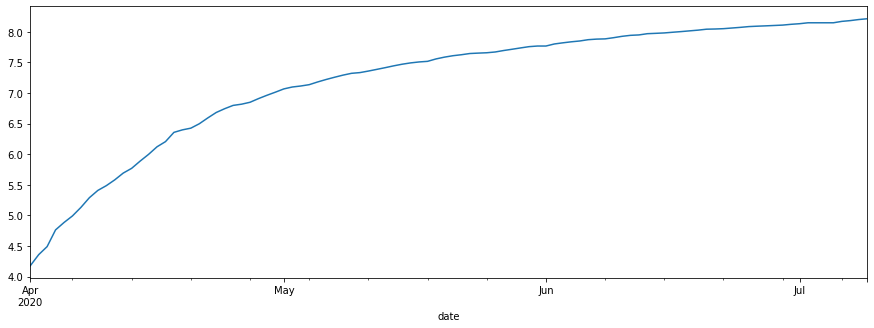

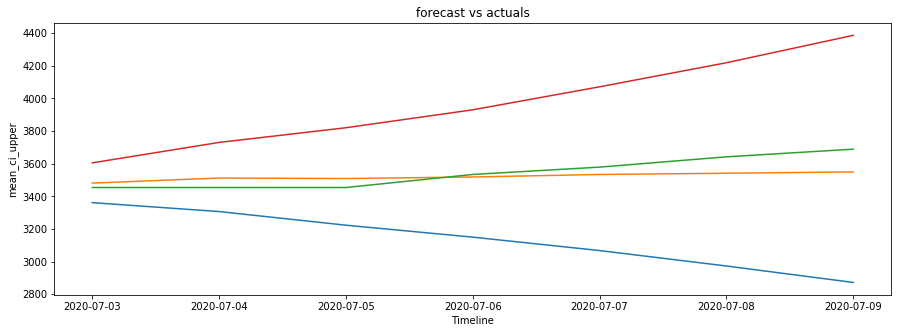

In [110]:
# deaths- scenario 1

# test for stationarity
adf_test(data.log_deaths)
kpss_test(data.log_deaths)

# modelling
endog = data1['log_deaths']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-07-02']
test_endog = endog['2020-07-03':'2020-07-09']
training_mod = sm.tsa.SARIMAX(training_endog, order=(14, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_deaths']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')



intercept   -0.000179
ar.L1       -0.374308
ar.L2       -0.079592
ar.L3       -0.007587
ma.L1       -0.326546
ma.L2       -0.056565
ma.L3        0.039335
ma.L4       -0.291853
ma.L5        0.033305
ma.L6       -0.001092
ma.L7        0.148290
sigma2       0.000006
dtype: float64
254.48046334642197 RMSE


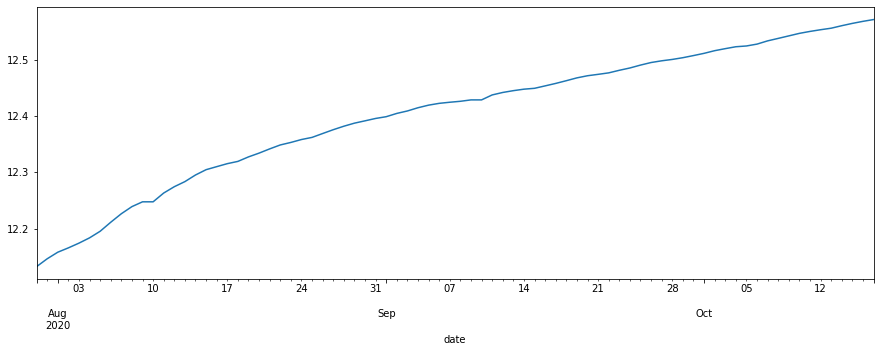

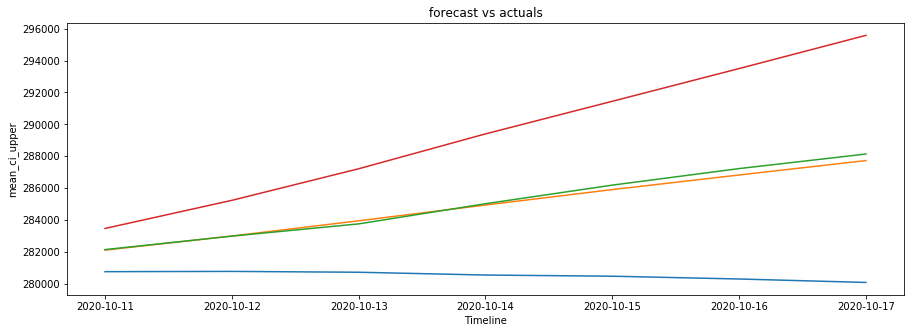

In [111]:
# cases -scenario 2
data1 = data[120:200]
endog = data1['log_cases']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-10-10']
test_endog = endog['2020-10-11':'2020-10-17']
training_mod = sm.tsa.SARIMAX(training_endog, order=(3, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_cases']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

intercept   -0.000118
ar.L1       -0.252416
ar.L2       -0.032119
ar.L3       -0.109241
ar.L4        0.071729
ar.L5       -0.059452
ar.L6        0.113203
ar.L7        0.146844
ar.L8        0.010001
ar.L9       -0.110328
ar.L10      -0.137403
ar.L11       0.004049
ar.L12      -0.134794
ar.L13       0.188357
ar.L14       0.216107
ma.L1       -0.205815
ma.L2       -0.005603
ma.L3       -0.181979
ma.L4       -0.007829
ma.L5       -0.166200
ma.L6        0.023015
ma.L7        0.248278
sigma2       0.000008
dtype: float64
40.61082036643791 RMSE


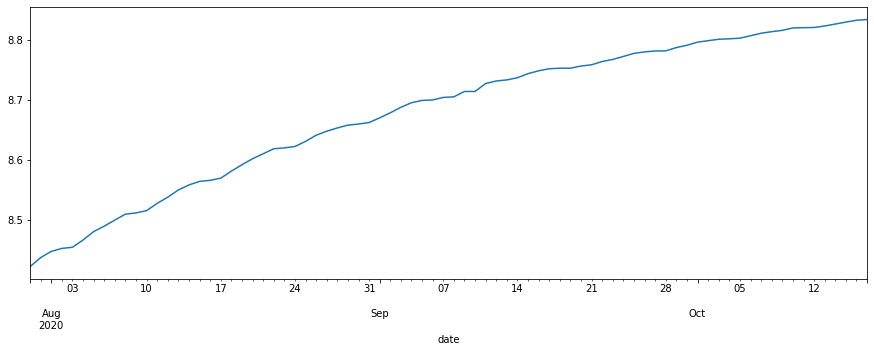

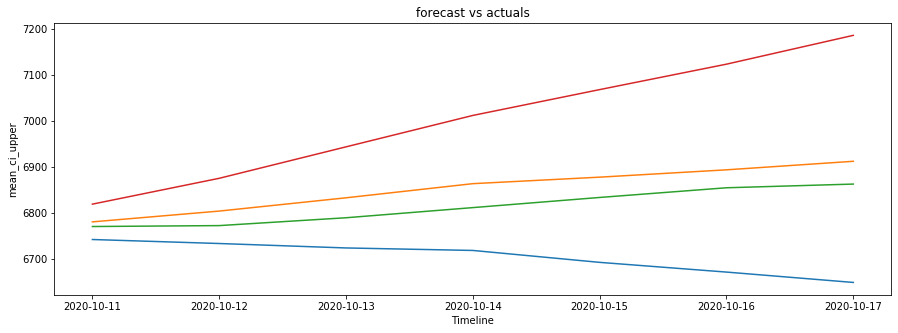

In [112]:
# deaths-scenario 2
data1 = data[120:200]
endog = data1['log_deaths']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-10-10']
test_endog = endog['2020-10-11':'2020-10-17']
training_mod = sm.tsa.SARIMAX(training_endog, order=(14, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_deaths']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

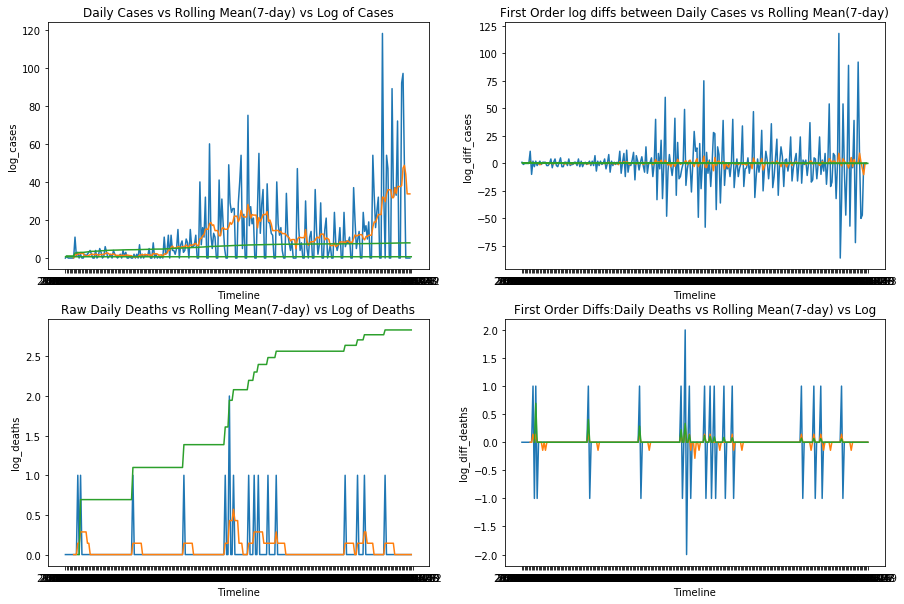

In [113]:
# Napa

Napa = cali[cali['CountyName'] == 'Napa']
Napa['daily_cases'] = Napa['n_cases'].diff()
Napa['daily_deaths'] = Napa['n_deaths'].diff()
Napa['one_diff_cases'] = Napa['daily_cases'].diff()
Napa['one_diff_deaths'] = Napa['daily_deaths'].diff()

#log

Napa['log_cases'] = np.log(Napa['n_cases'])
Napa['log_deaths'] = np.log(Napa['n_deaths'])
Napa['log_diff_cases'] = Napa['log_cases'].diff()
Napa['log_diff_deaths'] = Napa['log_deaths'].diff()


# Construct daily, log counts and first order differences within daily counts and log counts
df3 = Napa[['date', 'n_cases','n_deaths','daily_cases','daily_deaths', 'one_diff_cases','one_diff_deaths', 'log_cases', 'log_deaths',
              'log_diff_cases', 'log_diff_deaths']]


df3['rolling_mean_cases'] = Napa.daily_cases.rolling(window=7).mean()
df3['rolling_mean_deaths'] = Napa.daily_deaths.rolling(window=7).mean()
df3['rolling_mean_one_diff_cases'] = Napa.one_diff_cases.rolling(window=7).mean()
df3['rolling_mean_one_diff_deaths'] = Napa.one_diff_deaths.rolling(window=7).mean()

# Analysis of daily Infections & deaths
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.lineplot(data=df3, x="date", y="daily_cases")
sns.lineplot(data=df3, x="date", y="rolling_mean_cases")
sns.lineplot(data=df3, x="date", y="log_cases")
plt.xlabel("Timeline")
plt.title('Daily Cases vs Rolling Mean(7-day) vs Log of Cases')

plt.subplot(2,2,2)
sns.lineplot(data=df3, x="date", y="one_diff_cases")
sns.lineplot(data=df3, x="date", y="rolling_mean_one_diff_cases")
sns.lineplot(data=df3, x="date", y="log_diff_cases")
plt.xlabel("Timeline")
plt.title('First Order log diffs between Daily Cases vs Rolling Mean(7-day)')

plt.subplot(2,2,3)
sns.lineplot(data=df3, x="date", y="daily_deaths")
sns.lineplot(data=df3, x="date", y="rolling_mean_deaths")
sns.lineplot(data=df3, x="date", y="log_deaths")
plt.xlabel("Timeline")
plt.title('Raw Daily Deaths vs Rolling Mean(7-day) vs Log of Deaths')

plt.subplot(2,2,4)
sns.lineplot(data=df3, x="date", y="one_diff_deaths")
sns.lineplot(data=df3, x="date", y="rolling_mean_one_diff_deaths")
sns.lineplot(data=df3, x="date", y="log_diff_deaths")


plt.xlabel("Timeline")
plt.title('First Order Diffs:Daily Deaths vs Rolling Mean(7-day) vs Log')

plt.show()

# prepare data

df4 = df3.reset_index().drop('countyFIPS', axis = 1)
df4 = df4.set_index('date')
df4.index = pd.to_datetime(df4.index)
df4.index.freq = 'd'
data= df4['2020-04-01':]

Results of Dickey-Fuller Test:
Test Statistic                  -1.721175
p-value                          0.420237
#Lags Used                       8.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64
Results of KPSS Test:
Test Statistic            1.557928
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.000542
ar.L1       -0.929768
ar.L2       -0.866329
ar.L3       -0.331588
ma.L1       -0.171728
ma.L2        0.055052
ma.L3       -0.445795
ma.L4       -0.227664
ma.L5        0.013458
ma.L6       -0.209387
ma.L7        0.429236
sigma2       0.001060
dtype: float64
25.688715921759364 RMSE


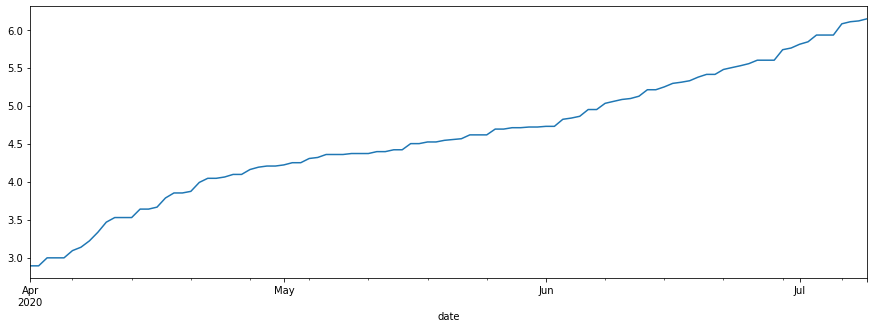

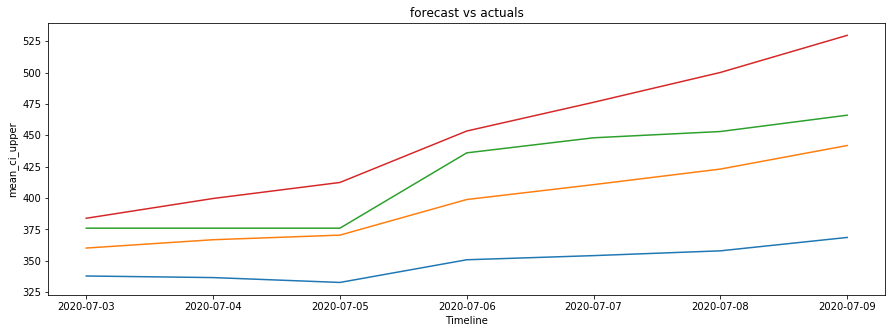

In [114]:
# cases-scenario 1

# test for stationarity
adf_test(data.log_cases)
kpss_test(data.log_cases)

# modelling

import statsmodels.api as sm
data1 = data[0:100]
endog = data1['log_cases']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-07-02']
test_endog = endog['2020-07-03':'2020-07-09']
training_mod = sm.tsa.SARIMAX(training_endog, order=(3, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_cases']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -0.798590
p-value                          0.819536
#Lags Used                       3.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64
Results of KPSS Test:
Test Statistic            1.568259
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.001339
ar.L1       -0.890021
ar.L2       -0.593508
ar.L3       -0.529988
ar.L4       -0.376106
ar.L5       -0.281563
ar.L6       -0.193844
ar.L7       -0.116495
ar.L8       -0.112713
ar.L9       -0.107192
ar.L10      -0.100402
ar.L11      -0.089646
ar.L12      -0.074827
ar.L13      -0.056379
ar.L14      -0.028743
ma.L1       -0.140768
ma.L2       -0.343987
ma.L3       -0.059611
ma.L4       -0.129035
ma.L5       -0.078959
ma.L6       -0.102214
ma.L7       -0.101849
sigma2       0.007601
dtype: float64
0.0027870721468285387 RMSE


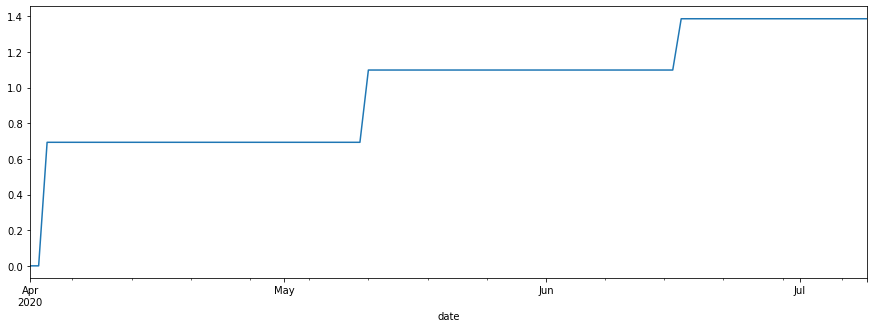

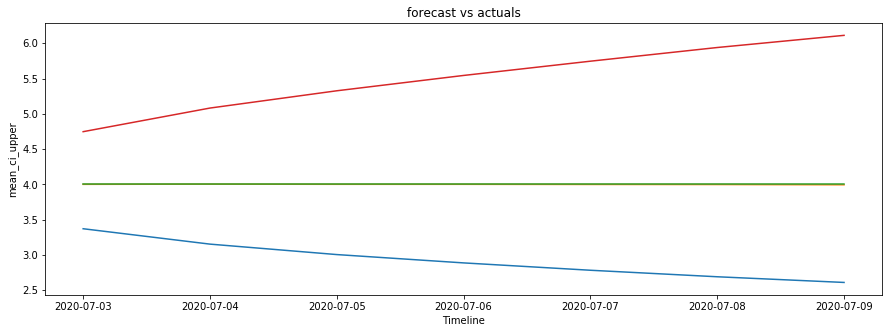

In [115]:
# deaths- scenario 1

# test for stationarity
adf_test(data.log_deaths)
kpss_test(data.log_deaths)

# modelling
endog = data1['log_deaths']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-07-02']
test_endog = endog['2020-07-03':'2020-07-09']
training_mod = sm.tsa.SARIMAX(training_endog, order=(14, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_deaths']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')

plt.show()


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.000827
ar.L1       -0.706625
ar.L2       -0.808873
ar.L3       -0.304827
ma.L1       -0.474978
ma.L2        0.105517
ma.L3       -0.290607
ma.L4       -0.255606
ma.L5       -0.107632
ma.L6       -0.062468
ma.L7        0.464556
sigma2       0.000115
dtype: float64
27.368083957310073 RMSE


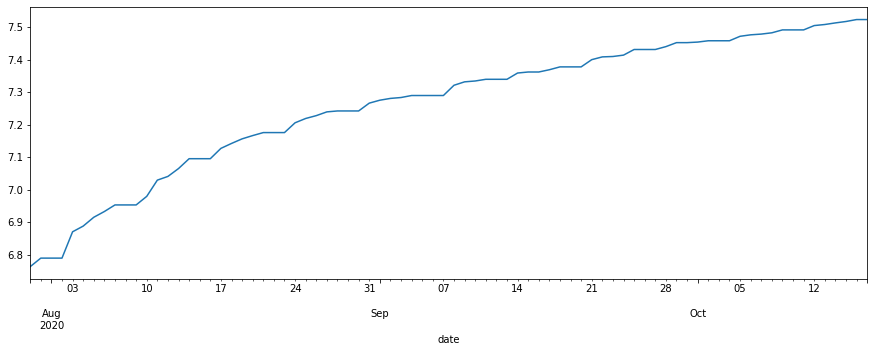

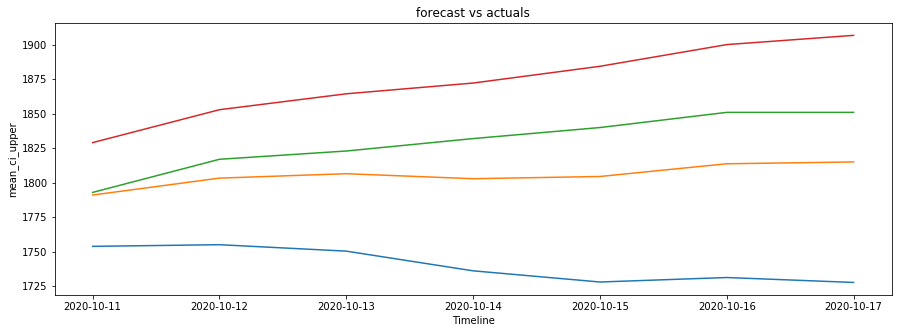

In [116]:
# cases -scenario 2
data1 = data[120:200]
endog = data1['log_cases']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-10-10']
test_endog = endog['2020-10-11':'2020-10-17']
training_mod = sm.tsa.SARIMAX(training_endog, order=(3, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_cases']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.001078
ar.L1       -0.625770
ar.L2       -0.309546
ar.L3       -0.261497
ar.L4       -0.203720
ar.L5       -0.081315
ar.L6        0.091158
ar.L7        0.071675
ar.L8       -0.146612
ar.L9       -0.231790
ar.L10      -0.046660
ar.L11      -0.205602
ar.L12      -0.266332
ar.L13       0.026522
ar.L14       0.329257
ma.L1       -0.480684
ma.L2       -0.392677
ma.L3       -0.054175
ma.L4        0.178297
ma.L5       -0.061047
ma.L6       -0.197965
ma.L7        0.271656
sigma2       0.000384
dtype: float64
1.121429725232361 RMSE


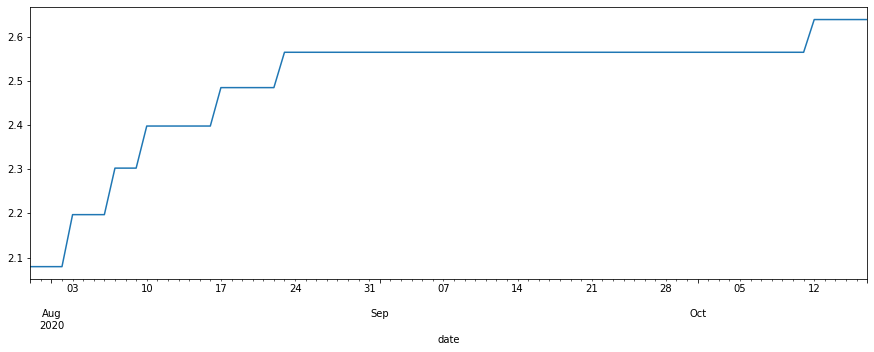

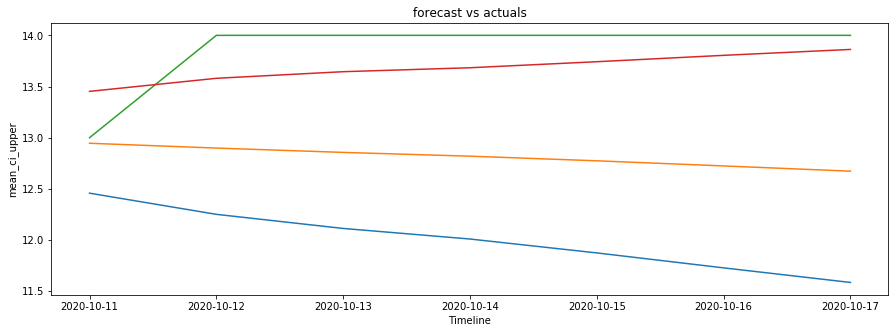

In [117]:
# deaths-scenario 2
data1 = data[120:200]
endog = data1['log_deaths']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-10-10']
test_endog = endog['2020-10-11':'2020-10-17']
training_mod = sm.tsa.SARIMAX(training_endog, order=(14, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_deaths']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

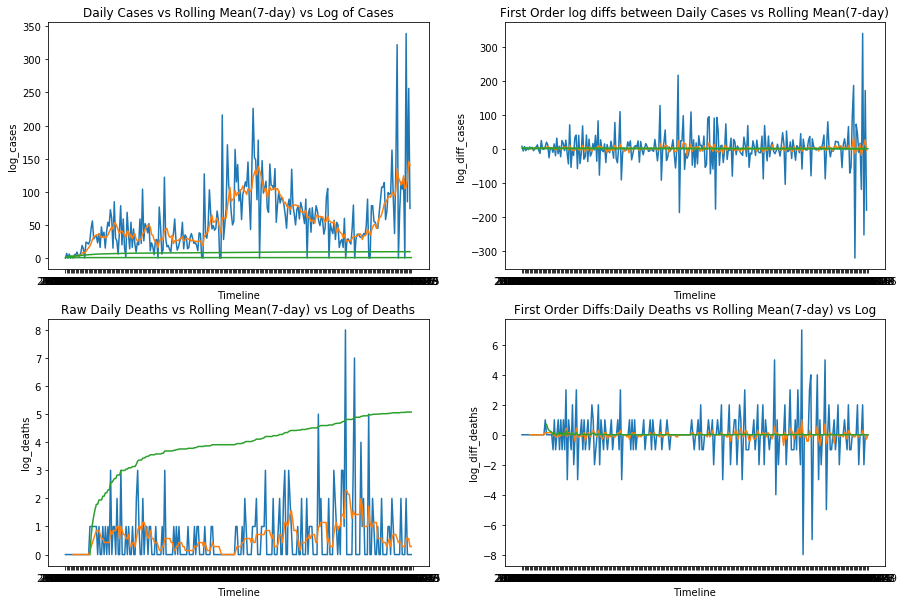

In [118]:
# Construct San Francisco county data

# Daily
San_fran = cali[cali['CountyName'] == 'San Francisco']
San_fran['daily_cases'] = San_fran['n_cases'].diff()
San_fran['daily_deaths'] = San_fran['n_deaths'].diff()
San_fran['one_diff_cases'] = San_fran['daily_cases'].diff()
San_fran['one_diff_deaths'] = San_fran['daily_deaths'].diff()

#log

San_fran['log_cases'] = np.log(San_fran['n_cases'])
San_fran['log_deaths'] = np.log(San_fran['n_deaths'])
San_fran['log_diff_cases'] = San_fran['log_cases'].diff()
San_fran['log_diff_deaths'] = San_fran['log_deaths'].diff()


# Construct daily, log counts and first order differences within daily counts and log counts
df3 = San_fran[['date', 'n_cases','n_deaths','daily_cases','daily_deaths', 'one_diff_cases','one_diff_deaths', 'log_cases', 'log_deaths',
              'log_diff_cases', 'log_diff_deaths']]

df3['rolling_mean_cases'] = San_fran.daily_cases.rolling(window=7).mean()
df3['rolling_mean_deaths'] = San_fran.daily_deaths.rolling(window=7).mean()
df3['rolling_mean_one_diff_cases'] = San_fran.one_diff_cases.rolling(window=7).mean()
df3['rolling_mean_one_diff_deaths'] = San_fran.one_diff_deaths.rolling(window=7).mean()


# Analysis of daily Infections & deaths
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.lineplot(data=df3, x="date", y="daily_cases")
sns.lineplot(data=df3, x="date", y="rolling_mean_cases")
sns.lineplot(data=df3, x="date", y="log_cases")
plt.xlabel("Timeline")
plt.title('Daily Cases vs Rolling Mean(7-day) vs Log of Cases')

plt.subplot(2,2,2)
sns.lineplot(data=df3, x="date", y="one_diff_cases")
sns.lineplot(data=df3, x="date", y="rolling_mean_one_diff_cases")
sns.lineplot(data=df3, x="date", y="log_diff_cases")
plt.xlabel("Timeline")
plt.title('First Order log diffs between Daily Cases vs Rolling Mean(7-day)')

plt.subplot(2,2,3)
sns.lineplot(data=df3, x="date", y="daily_deaths")
sns.lineplot(data=df3, x="date", y="rolling_mean_deaths")
sns.lineplot(data=df3, x="date", y="log_deaths")
plt.xlabel("Timeline")
plt.title('Raw Daily Deaths vs Rolling Mean(7-day) vs Log of Deaths')

plt.subplot(2,2,4)
sns.lineplot(data=df3, x="date", y="one_diff_deaths")
sns.lineplot(data=df3, x="date", y="rolling_mean_one_diff_deaths")
sns.lineplot(data=df3, x="date", y="log_diff_deaths")


plt.xlabel("Timeline")
plt.title('First Order Diffs:Daily Deaths vs Rolling Mean(7-day) vs Log')

plt.show()

# prepare data

df4 = df3.reset_index().drop('countyFIPS', axis = 1)
df4 = df4.set_index('date')
df4.index = pd.to_datetime(df4.index)
df4.index.freq = 'd'
data= df4['2020-04-01':]

Results of Dickey-Fuller Test:
Test Statistic                  -1.269791
p-value                          0.642877
#Lags Used                      15.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64
Results of KPSS Test:
Test Statistic            1.567045
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.001254
ar.L1       -0.454831
ar.L2       -0.025707
ar.L3       -0.446877
ma.L1       -0.489353
ma.L2       -0.272918
ma.L3        0.549626
ma.L4       -0.417329
ma.L5        0.159791
ma.L6       -0.075275
ma.L7       -0.004679
sigma2       0.000317
dtype: float64
88.8028588940433 RMSE


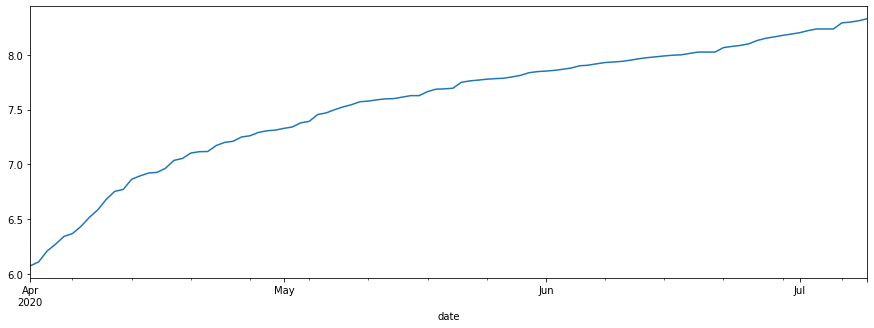

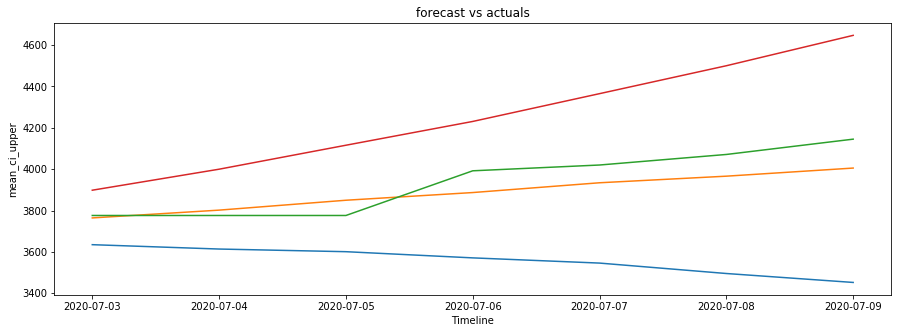

In [119]:
# cases-scenario 1

# test for stationarity
adf_test(data.log_cases)
kpss_test(data.log_cases)

# modelling

import statsmodels.api as sm
data1 = data[0:100]
endog = data1['log_cases']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-07-02']
test_endog = endog['2020-07-03':'2020-07-09']
training_mod = sm.tsa.SARIMAX(training_endog, order=(3, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_cases']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -1.190371
p-value                          0.677724
#Lags Used                      14.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64
Results of KPSS Test:
Test Statistic            1.536373
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.001711
ar.L1       -0.535129
ar.L2       -0.300181
ar.L3       -0.192987
ar.L4       -0.127362
ar.L5       -0.080850
ar.L6       -0.076562
ar.L7       -0.129653
ar.L8        0.013321
ar.L9        0.031170
ar.L10      -0.168311
ar.L11      -0.301007
ar.L12       0.044308
ar.L13      -0.057335
ar.L14       0.266073
ma.L1       -0.730818
ma.L2        0.127706
ma.L3       -0.036486
ma.L4       -0.095038
ma.L5        0.050805
ma.L6       -0.068098
ma.L7       -0.098919
sigma2       0.001170
dtype: float64
1.6799842527735382 RMSE


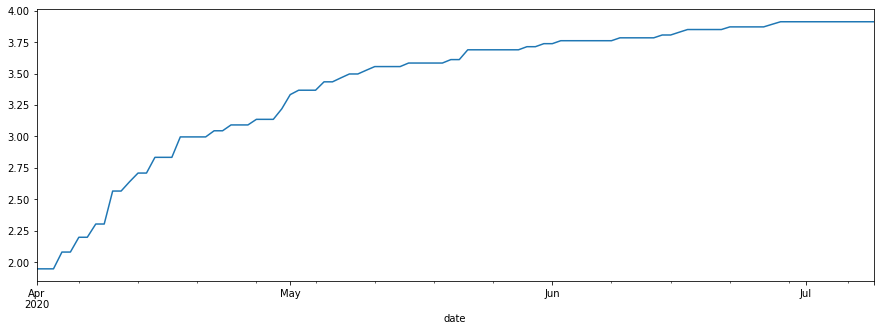

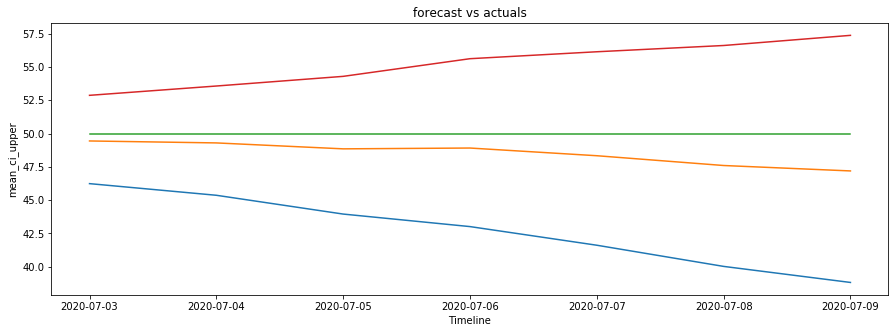

In [120]:
# deaths- scenario 1

# test for stationarity
adf_test(data.log_deaths)
kpss_test(data.log_deaths)

# modelling
endog = data1['log_deaths']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-07-02']
test_endog = endog['2020-07-03':'2020-07-09']
training_mod = sm.tsa.SARIMAX(training_endog, order=(14, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_deaths']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')

plt.show()

intercept   -0.000359
ar.L1       -0.394820
ar.L2       -0.234310
ar.L3       -0.118447
ma.L1       -0.692047
ma.L2       -0.070678
ma.L3        0.136591
ma.L4       -0.606084
ma.L5        0.275577
ma.L6        0.057971
ma.L7        0.049737
sigma2       0.000011
dtype: float64
79.22008713826092 RMSE


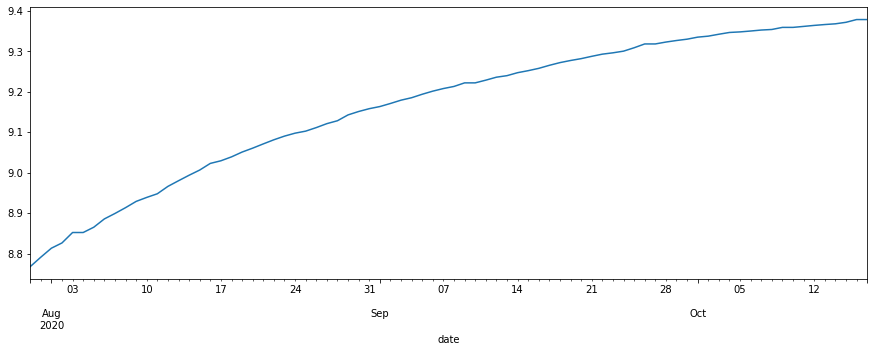

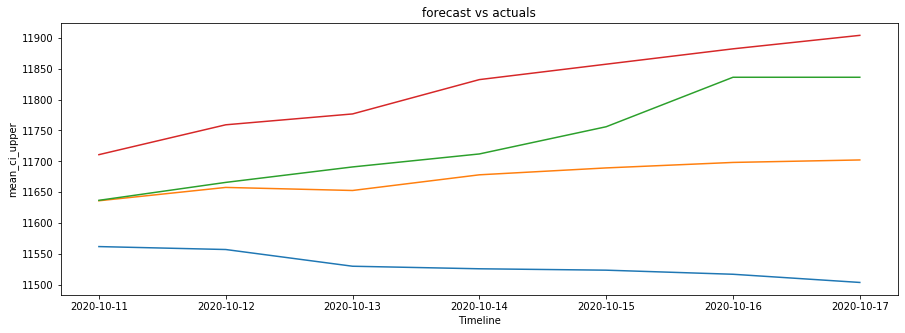

In [121]:
# cases -scenario 2
data1 = data[120:200]
endog = data1['log_cases']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-10-10']
test_endog = endog['2020-10-11':'2020-10-17']
training_mod = sm.tsa.SARIMAX(training_endog, order=(3, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_cases']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept    0.000093
ar.L1       -0.599528
ar.L2       -0.301012
ar.L3       -0.259551
ar.L4       -0.225201
ar.L5       -0.219053
ar.L6       -0.043784
ar.L7       -0.063738
ar.L8       -0.000022
ar.L9        0.069532
ar.L10      -0.148427
ar.L11      -0.174911
ar.L12      -0.212002
ar.L13       0.180646
ar.L14       0.065419
ma.L1       -0.302698
ma.L2       -0.358934
ma.L3       -0.093673
ma.L4       -0.000790
ma.L5       -0.148122
ma.L6       -0.096173
ma.L7        0.176248
sigma2       0.000201
dtype: float64
2.0416929959201564 RMSE


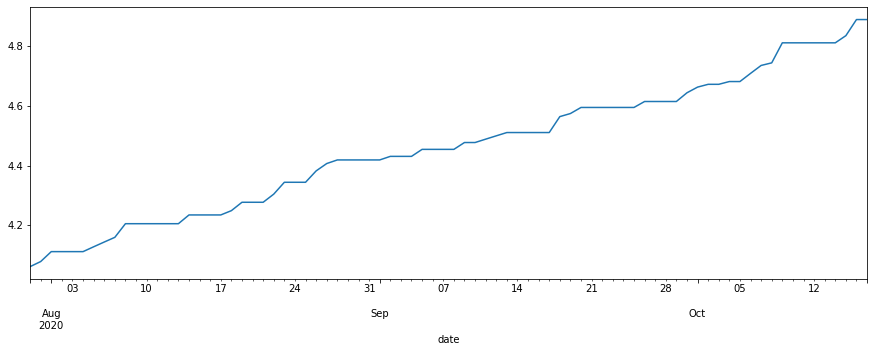

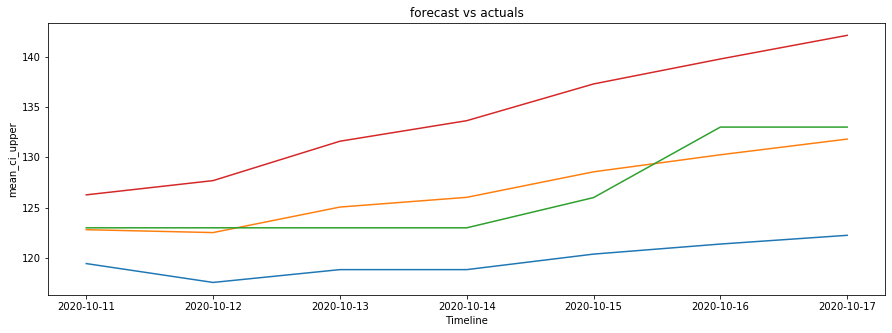

In [122]:
# deaths-scenario 2
data1 = data[120:200]
endog = data1['log_deaths']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-10-10']
test_endog = endog['2020-10-11':'2020-10-17']
training_mod = sm.tsa.SARIMAX(training_endog, order=(14, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_deaths']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

In [60]:
cali[cali['CountyName'] =='Contra Costa']

,CountyName,State,date,n_cases,n_deaths
countyFIPS,,,,,
6013,Contra Costa,California,2020-03-04,1,0
6013,Contra Costa,California,2020-03-05,1,0
6013,Contra Costa,California,2020-03-06,3,0
6013,Contra Costa,California,2020-03-07,3,0
6013,Contra Costa,California,2020-03-08,9,0
...,...,...,...,...,...
6013,Contra Costa,California,2020-11-25,23381,260
6013,Contra Costa,California,2020-11-26,23571,261
6013,Contra Costa,California,2020-11-27,23571,261


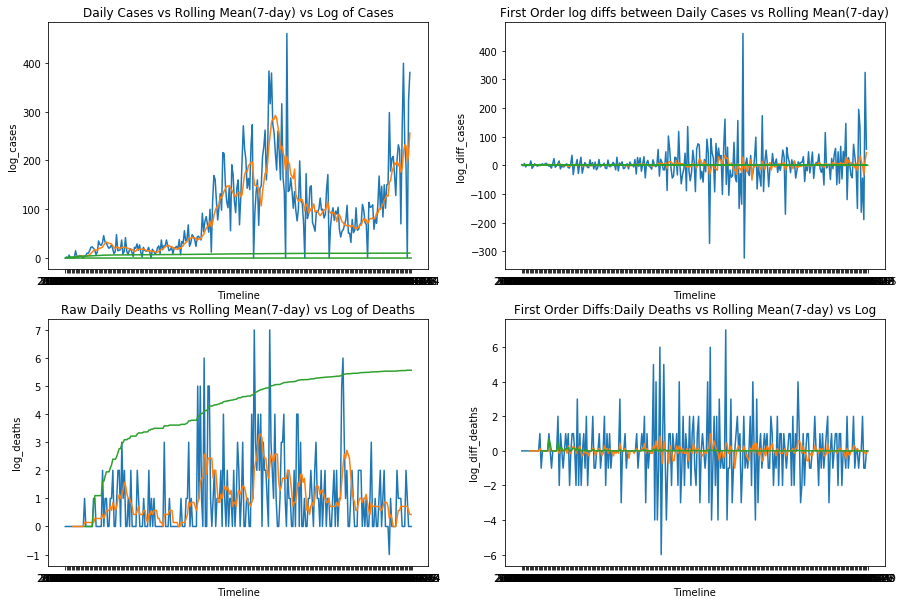

In [123]:
# Construct Contra Costa county data

# Daily
Contra_Costa = cali[cali['CountyName'] == 'Contra Costa']
Contra_Costa['daily_cases'] = Contra_Costa['n_cases'].diff()
Contra_Costa['daily_deaths'] = Contra_Costa['n_deaths'].diff()
Contra_Costa['one_diff_cases'] = Contra_Costa['daily_cases'].diff()
Contra_Costa['one_diff_deaths'] = Contra_Costa['daily_deaths'].diff()

#log

Contra_Costa['log_cases'] = np.log(Contra_Costa['n_cases'])
Contra_Costa['log_deaths'] = np.log(Contra_Costa['n_deaths'])
Contra_Costa['log_diff_cases'] = Contra_Costa['log_cases'].diff()
Contra_Costa['log_diff_deaths'] = Contra_Costa['log_deaths'].diff()


# Construct daily, log counts and first order differences within daily counts and log counts
df3 = Contra_Costa[['date', 'n_cases','n_deaths','daily_cases','daily_deaths', 'one_diff_cases','one_diff_deaths', 'log_cases', 'log_deaths',
              'log_diff_cases', 'log_diff_deaths']]

df3['rolling_mean_cases'] = Contra_Costa.daily_cases.rolling(window=7).mean()
df3['rolling_mean_deaths'] = Contra_Costa.daily_deaths.rolling(window=7).mean()
df3['rolling_mean_one_diff_cases'] = Contra_Costa.one_diff_cases.rolling(window=7).mean()
df3['rolling_mean_one_diff_deaths'] = Contra_Costa.one_diff_deaths.rolling(window=7).mean()


# Analysis of daily Infections & deaths
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.lineplot(data=df3, x="date", y="daily_cases")
sns.lineplot(data=df3, x="date", y="rolling_mean_cases")
sns.lineplot(data=df3, x="date", y="log_cases")
plt.xlabel("Timeline")
plt.title('Daily Cases vs Rolling Mean(7-day) vs Log of Cases')

plt.subplot(2,2,2)
sns.lineplot(data=df3, x="date", y="one_diff_cases")
sns.lineplot(data=df3, x="date", y="rolling_mean_one_diff_cases")
sns.lineplot(data=df3, x="date", y="log_diff_cases")
plt.xlabel("Timeline")
plt.title('First Order log diffs between Daily Cases vs Rolling Mean(7-day)')

plt.subplot(2,2,3)
sns.lineplot(data=df3, x="date", y="daily_deaths")
sns.lineplot(data=df3, x="date", y="rolling_mean_deaths")
sns.lineplot(data=df3, x="date", y="log_deaths")
plt.xlabel("Timeline")
plt.title('Raw Daily Deaths vs Rolling Mean(7-day) vs Log of Deaths')

plt.subplot(2,2,4)
sns.lineplot(data=df3, x="date", y="one_diff_deaths")
sns.lineplot(data=df3, x="date", y="rolling_mean_one_diff_deaths")
sns.lineplot(data=df3, x="date", y="log_diff_deaths")


plt.xlabel("Timeline")
plt.title('First Order Diffs:Daily Deaths vs Rolling Mean(7-day) vs Log')

plt.show()

# prepare data

df4 = df3.reset_index().drop('countyFIPS', axis = 1)
df4 = df4.set_index('date')
df4.index = pd.to_datetime(df4.index)
df4.index.freq = 'd'
data= df4['2020-04-01':]

Results of Dickey-Fuller Test:
Test Statistic                  -1.209116
p-value                          0.669662
#Lags Used                      14.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64
Results of KPSS Test:
Test Statistic            1.577374
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.002673
ar.L1       -1.022831
ar.L2       -0.801575
ar.L3       -0.456488
ma.L1        0.438179
ma.L2        0.162313
ma.L3        0.020569
ma.L4        0.083173
ma.L5        0.140196
ma.L6       -0.048430
ma.L7        0.044511
sigma2       0.000214
dtype: float64
77.08852065623446 RMSE


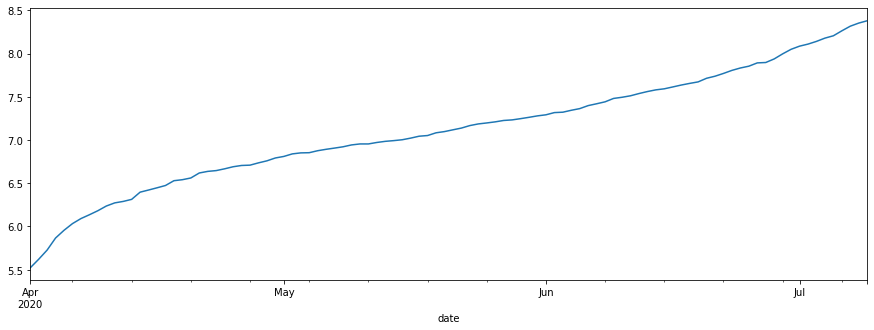

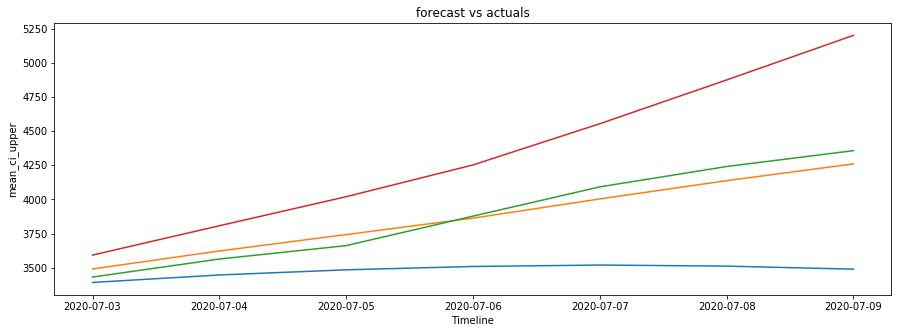

In [124]:
# cases-scenario 1

# test for stationarity
adf_test(data.log_cases)
kpss_test(data.log_cases)

# modelling

import statsmodels.api as sm
data1 = data[0:100]
endog = data1['log_cases']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-07-02']
test_endog = endog['2020-07-03':'2020-07-09']
training_mod = sm.tsa.SARIMAX(training_endog, order=(3, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_cases']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -1.736692
p-value                          0.412313
#Lags Used                      15.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64
Results of KPSS Test:
Test Statistic            1.536851
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.002789
ar.L1       -0.648239
ar.L2       -0.029851
ar.L3       -0.112124
ar.L4       -0.271543
ar.L5       -0.079753
ar.L6        0.000321
ar.L7       -0.076637
ar.L8        0.205767
ar.L9        0.170135
ar.L10      -0.238387
ar.L11      -0.273490
ar.L12       0.246715
ar.L13       0.368040
ar.L14      -0.091172
ma.L1       -0.479195
ma.L2       -0.245280
ma.L3       -0.098326
ma.L4       -0.009222
ma.L5        0.288241
ma.L6        0.040213
ma.L7       -0.184284
sigma2       0.002947
dtype: float64
2.963351303308679 RMSE


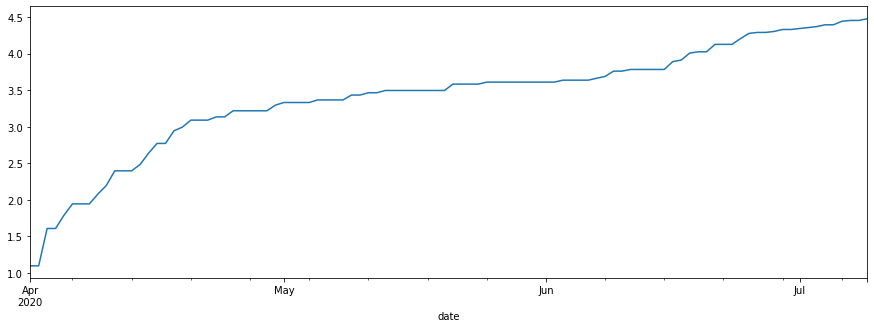

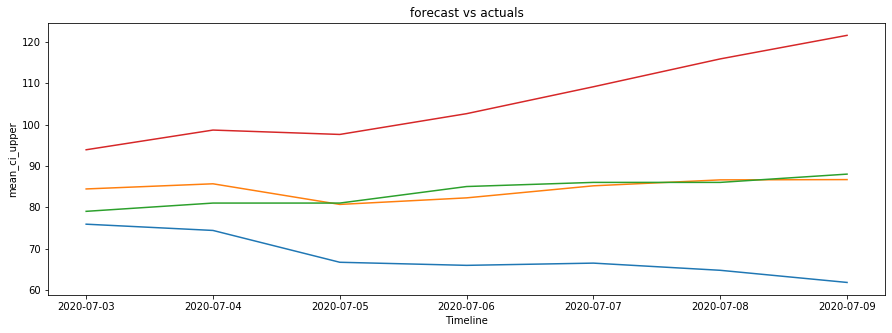

In [125]:
# deaths- scenario 1

# test for stationarity
adf_test(data.log_deaths)
kpss_test(data.log_deaths)

# modelling
endog = data1['log_deaths']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-07-02']
test_endog = endog['2020-07-03':'2020-07-09']
training_mod = sm.tsa.SARIMAX(training_endog, order=(14, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_deaths']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')

plt.show()

intercept   -0.000271
ar.L1       -0.827214
ar.L2       -0.169398
ar.L3        0.035494
ma.L1        0.080397
ma.L2       -0.375358
ma.L3       -0.088223
ma.L4        0.367254
ma.L5        0.097360
ma.L6       -0.029502
ma.L7        0.123300
sigma2       0.000034
dtype: float64
65.94500063054464 RMSE


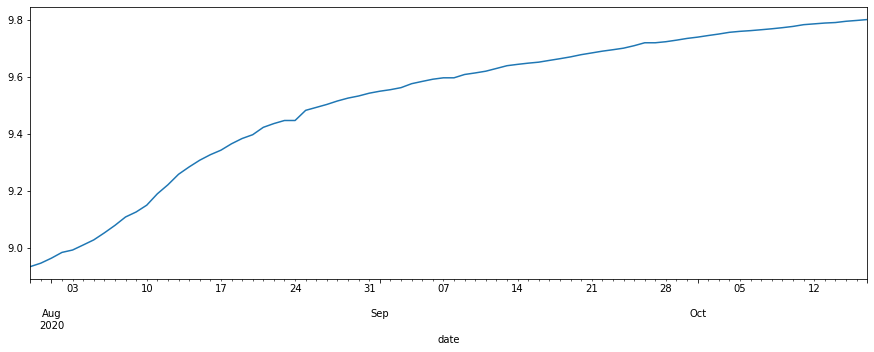

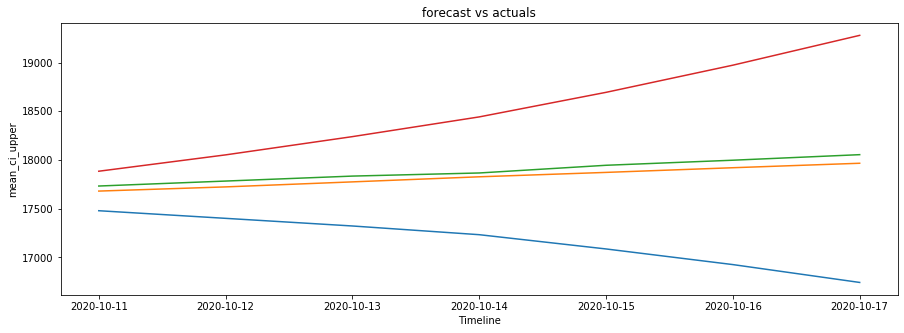

In [126]:
# cases -scenario 2
data1 = data[120:200]
endog = data1['log_cases']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-10-10']
test_endog = endog['2020-10-11':'2020-10-17']
training_mod = sm.tsa.SARIMAX(training_endog, order=(3, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_cases']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

/Users/raviivaturi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


intercept   -0.000168
ar.L1       -0.422506
ar.L2       -0.316560
ar.L3       -0.283565
ar.L4       -0.134100
ar.L5       -0.125606
ar.L6       -0.168354
ar.L7        0.034258
ar.L8       -0.051199
ar.L9        0.191214
ar.L10       0.160267
ar.L11       0.359742
ar.L12       0.054941
ar.L13       0.113648
ar.L14       0.147503
ma.L1       -0.416562
ma.L2       -0.053067
ma.L3       -0.125358
ma.L4       -0.081508
ma.L5        0.153684
ma.L6       -0.190175
ma.L7       -0.006451
sigma2       0.000069
dtype: float64
7.601372634832044 RMSE


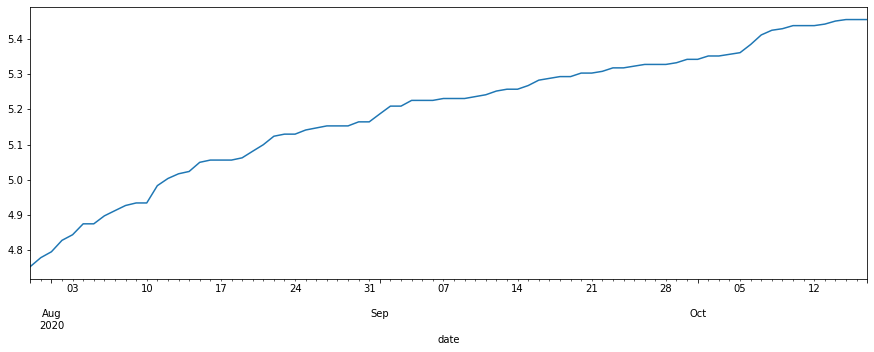

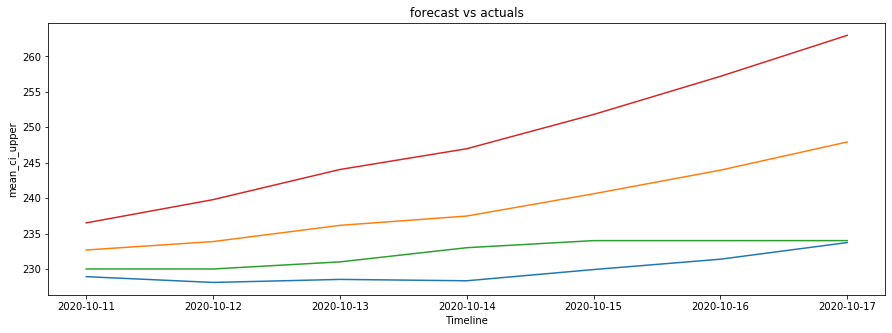

In [127]:
# deaths-scenario 2
data1 = data[120:200]
endog = data1['log_deaths']
endog.plot(figsize=(15, 5))

# Step 1: fit model parameters w/ training sample

training_endog = endog[:'2020-10-10']
test_endog = endog['2020-10-11':'2020-10-17']
training_mod = sm.tsa.SARIMAX(training_endog, order=(14, 2, 7), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

# Step 2: produce one-step-ahead forecasts
log_fcast = training_res.get_forecast(7)
results = np.exp(log_fcast.summary_frame())
results['actuals'] = data1['n_deaths']
results = results.drop('mean_se', axis =1)
results = results.rename(columns={"mean":"fcast"}, copy =False)
rmse = np.sqrt(((results.actuals - results.fcast)**2).mean())
print(rmse, "RMSE")

# plot results
plt.figure(figsize=(15,5))

sns.lineplot(data = results, x= results.index, y="mean_ci_lower")
sns.lineplot(data = results, x= results.index, y="fcast")
sns.lineplot(data = results, x= results.index, y="actuals")
sns.lineplot(data = results, x= results.index, y="mean_ci_upper")

plt.xlabel("Timeline")
plt.title('forecast vs actuals')


plt.show()

In [70]:
data.tail(8)

,n_cases,n_deaths,daily_cases,daily_deaths,one_diff_cases,one_diff_deaths,log_cases,log_deaths,log_diff_cases,log_diff_deaths,rolling_mean_cases,rolling_mean_deaths,rolling_mean_one_diff_cases,rolling_mean_one_diff_deaths
date,,,,,,,,,,,,,,
2020-11-22,22482,258,70.0,0.0,-151.0,-1.0,10.020470,5.552960,0.003118,0.000000,176.000000,0.714286,-19.142857,0.000000
2020-11-23,22747,258,265.0,0.0,195.0,0.0,10.032189,5.552960,0.011718,0.000000,184.142857,0.714286,8.142857,0.000000
2020-11-24,23146,258,399.0,0.0,134.0,0.0,10.049577,5.552960,0.017389,0.000000,216.571429,0.714286,32.428571,0.000000
2020-11-25,23381,260,235.0,2.0,-164.0,2.0,10.059679,5.560682,0.010102,0.007722,231.857143,0.714286,15.285714,0.000000
2020-11-26,23571,261,190.0,1.0,-45.0,-1.0,10.067772,5.564520,0.008093,0.003839,230.285714,0.714286,-1.571429,0.000000
2020-11-27,23571,261,0.0,0.0,-190.0,-1.0,10.067772,5.564520,0.000000,0.000000,197.142857,0.571429,-33.142857,-0.142857
2020-11-28,23895,261,324.0,0.0,324.0,0.0,10.081425,5.564520,0.013652,0.000000,211.857143,0.428571,14.714286,-0.142857
2020-11-29,24275,261,380.0,0.0,56.0,0.0,10.097202,5.564520,0.015778,0.000000,256.142857,0.428571,44.285714,0.000000
